<a href="https://colab.research.google.com/github/lee3072/cs390nip-lab4/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

s: 0.622106.
	Epoch 9814:
		Discriminator loss: 0.754362.
		Discriminator accuracy: 42.19%.
		Generator loss: 0.610047.
	Epoch 9815:
		Discriminator loss: 0.740179.
		Discriminator accuracy: 32.81%.
		Generator loss: 0.586666.
	Epoch 9816:
		Discriminator loss: 0.749977.
		Discriminator accuracy: 34.38%.
		Generator loss: 0.596132.
	Epoch 9817:
		Discriminator loss: 0.739156.
		Discriminator accuracy: 35.94%.
		Generator loss: 0.625050.
	Epoch 9818:
		Discriminator loss: 0.748042.
		Discriminator accuracy: 34.38%.
		Generator loss: 0.617162.
	Epoch 9819:
		Discriminator loss: 0.748402.
		Discriminator accuracy: 31.25%.
		Generator loss: 0.605486.
	Epoch 9820:
		Discriminator loss: 0.748457.
		Discriminator accuracy: 29.69%.
		Generator loss: 0.628794.
	Epoch 9821:
		Discriminator loss: 0.745757.
		Discriminator accuracy: 37.50%.
		Generator loss: 0.652090.
	Epoch 9822:
		Discriminator loss: 0.749396.
		Discriminator accuracy: 35.94%.
		Generator loss: 0.669931.
	Epoch 9823:
		Discrimin

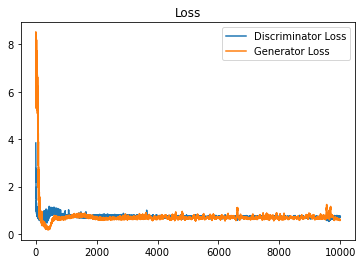

In [3]:
# git commit testing from google colab
# CS390-NIP GAN lab
# Max Jacobson / Sri Cherukuri / Anthony Niemiec
# FA2020
# uses Fashion MNIST https://www.kaggle.com/zalando-research/fashionmnist 
# uses CIFAR-10 https://www.cs.toronto.edu/~kriz/cifar.html

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adam
from scipy.misc import imsave
import random

random.seed(1618)
np.random.seed(1618)
tf.compat.v1.set_random_seed(1618)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# NOTE: mnist_d is no credit
# NOTE: cifar_10 is extra credit
#DATASET = "mnist_d"
DATASET = "mnist_f"
#DATASET = "cifar_10"

if DATASET == "mnist_d":
    IMAGE_SHAPE = (IH, IW, IZ) = (28, 28, 1)
    LABEL = "numbers"

elif DATASET == "mnist_f":
    IMAGE_SHAPE = (IH, IW, IZ) = (28, 28, 1)
    CLASSLIST = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    # TODO: choose a label to train on from the CLASSLIST above
    # LABEL = "shirt"
    # LABEL = "ankle boot"
    LABEL = "bag"

elif DATASET == "cifar_10":
    IMAGE_SHAPE = (IH, IW, IZ) = (32, 32, 3)
    CLASSLIST = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    LABEL = "airplane"

IMAGE_SIZE = IH*IW*IZ

NOISE_SIZE = 100    # length of noise array

# file prefixes and directory
OUTPUT_NAME = DATASET + "_" + LABEL
OUTPUT_DIR = "./drive/My Drive/Colab Notebooks/lab4 outputs/" + OUTPUT_NAME

# NOTE: switch to True in order to receive debug information
VERBOSE_OUTPUT = False

################################### DATA FUNCTIONS ###################################

# Load in and report the shape of dataset
def getRawData():
    if DATASET == "mnist_f":
        (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.fashion_mnist.load_data()
    elif DATASET == "cifar_10":
        (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
    elif DATASET == "mnist_d":
        (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    print("Shape of xTrain dataset: %s." % str(xTrain.shape))
    print("Shape of yTrain dataset: %s." % str(yTrain.shape))
    print("Shape of xTest dataset: %s." % str(xTest.shape))
    print("Shape of yTest dataset: %s." % str(yTest.shape))
    return ((xTrain, yTrain), (xTest, yTest))

# Filter out the dataset to only include images with our LABEL, meaning we may also discard
# class labels for the images because we know exactly what to expect
def preprocessData(raw):
    ((xTrain, yTrain), (xTest, yTest)) = raw
    if DATASET == "mnist_d":
        xP = np.r_[xTrain, xTest]
    else:
        c = CLASSLIST.index(LABEL)
        x = np.r_[xTrain, xTest]
        y = np.r_[yTrain, yTest].flatten()
        ilist = [i for i in range(y.shape[0]) if y[i] == c]
        xP = x[ilist]
    # NOTE: Normalize from 0 to 1 or -1 to 1
    #xP = xP/255.0
    xP = xP/127.5 - 1
    print("Shape of Preprocessed dataset: %s." % str(xP.shape))
    return xP


################################### CREATING A GAN ###################################

# Model that discriminates between fake and real dataset images
def buildDiscriminator():
    model = Sequential()
    
    # DONE: build a discriminator which takes in a (28 x 28 x 1) image - possibly from mnist_f  | Reference: Gan Class Slide Page 12
    #       and possibly from the generator - and outputs a single digit REAL (1) or FAKE (0)
    # model.add(Flatten(input_shape = IMAGE_SHAPE))
    # model.add(Dense(512))
    # model.add(LeakyReLU(alpha = 0.2)) # NOTE: LeakyReLU multiplies alpha value if the ouput is lower than 0
    # model.add(Dense(256))
    # model.add(LeakyReLU(alpha = 0.2))
    # model.add(Dense(1, activation = "sigmoid"))

    # TODO: CONVNET VERSION | Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))


    # Creating a Keras Model out of the network
    inputTensor = Input(shape = IMAGE_SHAPE)
    return Model(inputTensor, model(inputTensor))

# Model that generates a fake image from random noise
def buildGenerator():
    model = Sequential()

    # DONE: build a generator which takes in a (NOISE_SIZE) noise array and outputs a fake.    | Reference: Gan Class Slide Page 10
    #       mnist_f (28 x 28 x 1) image
    # model.add(Dense(256, input_dim=NOISE_SIZE))
    # model.add(LeakyReLU(alpha = 0.2))
    # model.add(BatchNormalization(momentum = 0.8))
    # model.add(Dense(512))
    # model.add(LeakyReLU(alpha = 0.2))
    # model.add(BatchNormalization(momentum = 0.8))
    # model.add(Dense(1024))
    # model.add(LeakyReLU(alpha = 0.2))
    # model.add(BatchNormalization(momentum = 0.8))
    # model.add(Dense(IMAGE_SIZE, activation = "tanh"))
    # model.add(Reshape(IMAGE_SHAPE))

    # TODO: CONVNET VERSION | Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    model.add(Dense(7*7*256, use_bias=False, input_dim=NOISE_SIZE))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    # Creating a Keras Model out of the network
    inputTensor = Input(shape = (NOISE_SIZE,))
    return Model(inputTensor, model(inputTensor))

def buildGAN(images, epochs = 40000, batchSize = 32, loggingInterval = 0):
    learning_rate = 0.002
    dis_vs_gen_ratio = 0.0054
    # Setup
    opt_dis = Adam(lr = learning_rate * dis_vs_gen_ratio) # NOTE: this is the learning rate for both discriminator and generator
    opt_gen = Adam(lr = learning_rate) # NOTE: this is the learning rate for both discriminator and generator
    loss = "binary_crossentropy"

    # Setup adversary
    adversary = buildDiscriminator()
    adversary.compile(loss = loss, optimizer = opt_dis, metrics = ["accuracy"])

    # Setup generator and GAN
    adversary.trainable = False                     # freeze adversary's weights when training GAN
    generator = buildGenerator()                    # generator is trained within GAN in relation to adversary performance
    noise = Input(shape = (NOISE_SIZE,))
    gan = Model(noise, adversary(generator(noise))) # GAN feeds generator into adversary
    gan.compile(loss = loss, optimizer = opt_gen)

    # Training
    trueCol = np.ones((batchSize, 1))
    falseCol = np.zeros((batchSize, 1))

    #discriminator and generator loss record
    discriminator_loss_record =[]
    generator_loss_record = []
    accuracy = []
    for epoch in range(epochs):

        # Train discriminator with a true and false batch
        batch = images[np.random.randint(0, images.shape[0], batchSize)]
        noise = np.random.normal(0, 1, (batchSize, NOISE_SIZE))
        genImages = generator.predict(noise)
        advTrueLoss = adversary.train_on_batch(batch, trueCol)
        advFalseLoss = adversary.train_on_batch(genImages, falseCol)
        advLoss = np.add(advTrueLoss, advFalseLoss) * 0.5

        # Train generator by training GAN while keeping adversary component constant
        noise = np.random.normal(0, 1, (batchSize, NOISE_SIZE))
        genLoss = gan.train_on_batch(noise, trueCol)

        #append to record of loss
        discriminator_loss_record.append(advLoss[0])
        generator_loss_record.append(genLoss)
        # accuracy.append(advLoss[1])

        print("\tEpoch %d:" % epoch)
        print("\t\tDiscriminator loss: %f." % advLoss[0])
        print("\t\tDiscriminator accuracy: %.2f%%." % (100 * advLoss[1]))
        print("\t\tGenerator loss: %f." % genLoss)
        # Logging
        if loggingInterval > 0 and epoch % loggingInterval == 0:
            runGAN(generator, OUTPUT_DIR + "/" + OUTPUT_NAME + "_test_%d.png" % (epoch / loggingInterval))
            # plt.title("Loss until epoch %d" % epoch)
            # plt.plot(discriminator_loss_record, label="Discriminator Loss")
            # plt.plot(generator_loss_record, label="Generator Loss")
            # # plt.plot(accuracy, label="Accuracy")
            # plt.legend()
            # plt.savefig("./drive/My Drive/Colab Notebooks/lab4 outputs/"+DATASET+"_loss_plot_%d.png" % (epoch / loggingInterval))
            # plt.clf()
    plt.title("Loss")
    plt.plot(discriminator_loss_record, label="Discriminator Loss")
    plt.plot(generator_loss_record, label="Generator Loss")
    plt.legend()
    plt.savefig("./drive/My Drive/Colab Notebooks/lab4 outputs/"+DATASET+"_loss_plot_"+LABEL+".png")
    return (generator, adversary, gan)

# Generates an image using given generator
def runGAN(generator, outfile):
    noise = np.random.normal(0, 1, (1, NOISE_SIZE)) # generate a random noise array
    img = generator.predict(noise)[0]               # run generator on noise
    img = np.squeeze(img)                           # readjust image shape if needed
    img = (0.5*img + 0.5)*255                       # adjust values to range from 0 to 255 as needed
    imsave(outfile, img)                            # store resulting image


################################### RUNNING THE PIPELINE #############################

def main():
    print("Starting %s image generator program." % LABEL)
    # Make output directory
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    # Receive all of mnist_f
    raw = getRawData()
    # Filter for just the class we are trying to generate
    data = preprocessData(raw)
    # Create and train all facets of the GAN
    (generator, adv, gan) = buildGAN(data, epochs = 10000, loggingInterval = 100)
    # Utilize our spooky neural net gimmicks to create realistic counterfeit images
    for i in range(10):
        runGAN(generator, OUTPUT_DIR + "/" + OUTPUT_NAME + "_final_%d.png" % i)
    print("Images saved in %s directory." % OUTPUT_DIR)

if __name__ == '__main__':
    main()

In [ ]:
!pip install -U scipy==1.2.0